In [ ]:
from math import sqrt 
import datetime as dt
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import time
import json
import tensorflow as tf
import collections

from matplotlib import pyplot
from matplotlib.cm import get_cmap
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error, accuracy_score
from keras.models import Sequential, model_from_json
from keras.layers import Dense, LSTM, Dropout
from keras import backend as K
from imblearn.combine import SMOTEENN

%matplotlib inline

#Funciones

In [ ]:
def helada(row):
  if row['Y'] <= 0:
    return 0
  else: 
    return 1 

#Parámetros

In [ ]:
look_back=18
col=['LowTemp','OutHum','DewPt']
colnames= []

In [ ]:
def coeff_determination(y_true, y_pred):
  SS_res =  K.sum(K.square( y_true-y_pred )) 
  SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
  return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#Preprocesamiento

In [ ]:
for i in range(look_back): 
  for s in col:
    colnames.append(s+str(i+1))

cantCaract= len(colnames)

colnames.append("Y")
colnames2= colnames.copy() # los datos de entrenamiento y validacion no tienen fecha
colnames.append("DateTime")

In [ ]:
df_sftrain= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datos2/Temp_Hum_DewPt_Smoteen_vent3_hor3_train.csv', usecols=colnames2,low_memory=False)
df_sfval= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datos2/Temp_Hum_DewPt_Smoteen_vent3_hor3_val.csv', usecols=colnames2,low_memory=False)

In [ ]:
df_inta = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datos/datosINTA_TempHumRocioVientoRadBarHora_conVentana3hs_3hshorizonte.csv', usecols=colnames,low_memory=False)
df_inta['DateTime'] = pd.to_datetime(df_inta['DateTime'], format='%Y-%m-%d %H:%M:%S')
df_inta= df_inta.sort_values(by='DateTime')

In [ ]:
col_num= colnames[:cantCaract+1]
for c in col_num:
  df_inta[c].mask(df_inta[c] == '---',0,inplace=True)
  df_inta[c]= pd.to_numeric(df_inta[c])  

[34000, 11058] [31643, 10810]
Counter({True: 34000, False: 31643}) Counter({True: 11058, False: 10810})


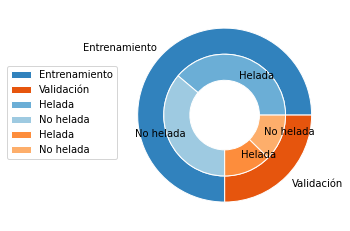

In [ ]:
heladas=[]
noheladas=[]
canth= df_sftrain['Y']<=0
canthval= df_sfval['Y']<=0
counterh = collections.Counter(canth)
counterhval= collections.Counter(canthval)
subindice=[True, False]

heladas.append(counterh[subindice[0]])
heladas.append(counterhval[subindice[0]])
noheladas.append(counterh[subindice[1]])
noheladas.append(counterhval[subindice[1]])

valtrain= [heladas[0], noheladas[0]]
valval= [heladas[1], noheladas[1]]
print(heladas, noheladas)
print(counterh, counterhval)

#grafica

fig, ax = plt.subplots()
size = 0.3
vals = np.array([valtrain, valval])

cmap = get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap([1, 2, 5, 6])

labels_inner = ["Helada", "No helada", "Helada", "No helada"]
labels_outer = ["Entrenamiento", "Validación"]

# outer slices
ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=labels_outer)

# inner slices
ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=labels_inner, labeldistance=0.7)

#ax.set(aspect="equal", title='Conjunto de datos')
plt.legend(loc=(-0.5, 0.3))
ax.set(aspect="equal")

plt.show()

In [ ]:
df_test= df_inta

In [ ]:
len(df_sfval) *100/(len(df_sftrain)+len(df_sfval))

24.98885854349739

In [ ]:
print(len(df_sftrain), len(df_sfval))

65643 21868


In [ ]:
xtrain= df_sftrain.iloc[:,0:cantCaract]
ytrain= df_sftrain.loc[:,'Y']
xval= df_sfval.iloc[:,0:cantCaract]
yval= df_sfval.loc[:,'Y']
xtest= df_test.iloc[:,0:cantCaract]
ytest= df_test.loc[:,'Y']

#** estandariza**

In [ ]:
scalerX = StandardScaler()
scalerY = StandardScaler()

dataX= pd.concat([xtrain, xval, xtest], axis=0)
dataY= pd.concat([ytrain, yval, ytest], axis=0)

dataX= dataX.to_numpy()
print('----------X---------')
print(scalerX.fit(dataX.astype('float32')))
print('-------------------')
print(scalerX.mean_)
print(len(scalerX.mean_))

dataY= dataY.to_numpy().reshape(-1,1)
print('----------Y---------')
print(scalerY.fit(dataY.astype('float32')))
print('-------------------')
print(scalerY.mean_)

----------X---------
StandardScaler()
-------------------
[ 6.56755438e+00  6.77911840e+01  2.76566888e-01  6.36163710e+00
  6.83503744e+01  2.31938370e-01  6.15835607e+00  6.88980558e+01
  1.86368969e-01  5.96032113e+00  6.94282932e+01  1.38926579e-01
  5.76960289e+00  6.99342534e+01  9.00805793e-02  5.58792116e+00
  7.04157684e+01  4.18680516e-02  5.41738269e+00  7.08681374e+01
 -6.24491584e-03  5.25826313e+00  7.12930979e+01 -5.33830473e-02
  5.11016248e+00  7.16878463e+01 -9.98264199e-02  4.97251587e+00
  7.20572513e+01 -1.44681612e-01  4.84403160e+00  7.24015312e+01
 -1.88171501e-01  4.72340876e+00  7.27212317e+01 -2.31088311e-01
  4.60922031e+00  7.30256623e+01 -2.72396368e-01  4.50028038e+00
  7.33148988e+01 -3.13038730e-01  4.39588091e+00  7.35915517e+01
 -3.53159265e-01  4.29470153e+00  7.38589033e+01 -3.92655930e-01
  4.19604909e+00  7.41182633e+01 -4.31951740e-01  4.09991978e+00
  7.43702361e+01 -4.71099831e-01]
54
----------Y---------
StandardScaler()
-------------------
[2

In [ ]:
trainX_scaler= scalerX.transform(xtrain.to_numpy())
trainY_scaler= scalerY.transform(ytrain.to_numpy().reshape(-1,1))
validationX_scaler= scalerX.transform(xval.to_numpy())
validationY_scaler= scalerY.transform(yval.to_numpy().reshape(-1,1))
testX_scaler= scalerX.transform(xtest.to_numpy())
testY_scaler= scalerY.transform(ytest.to_numpy().reshape(-1,1))

In [ ]:
trainX_scaler = np.reshape(trainX_scaler, (trainX_scaler.shape[0], look_back, len(col)))
validationX_scaler = np.reshape(validationX_scaler, (validationX_scaler.shape[0], look_back, len(col)))
testX_scaler = np.reshape(testX_scaler, (testX_scaler.shape[0], look_back, len(col)))

In [ ]:
print(trainX_scaler.shape, trainY_scaler.shape)
print(validationX_scaler.shape, validationY_scaler.shape)
print(testX_scaler.shape, testY_scaler.shape)

(65643, 18, 3) (65643, 1)
(21868, 18, 3) (21868, 1)
(31613, 18, 3) (31613, 1)


#Entrenamiento

In [ ]:
def modelo(n_time_step, n_features, neuron):
  lr= 8e-7
  model = Sequential()
  model.add(LSTM(neuron, activation= "relu",input_shape=(n_time_step, n_features))) 
  model.add(Dense(1))
  model.compile(loss='mse',optimizer= tf.keras.optimizers.Adam(learning_rate=lr), metrics=['mse'])  
  model.summary()
  return model

In [ ]:
neurons=[18*len(col)]
num_epochs = [80]
cantidad_modelos= len(num_epochs)
models = []
histories=[]

In [ ]:
for i in range(cantidad_modelos):  
  model = modelo(look_back,len(col),neurons[0])
  models.append(model)
  start_time= time.time()
  history= model.fit(trainX_scaler, trainY_scaler,epochs = num_epochs[i], verbose=0, validation_data= (validationX_scaler, validationY_scaler))
  end_time= time.time()
  print('duracion del entrenamiento: ', end_time - start_time)
  histories.append(pd.DataFrame(history.history))
  
  model.reset_states()    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 54)                12528     
                                                                 
 dense (Dense)               (None, 1)                 55        
                                                                 
Total params: 12,583
Trainable params: 12,583
Non-trainable params: 0
_________________________________________________________________
duracion del entrenamiento:  1643.7958841323853


In [ ]:
def plot_history(hist, epochs):
  #hist = pd.DataFrame(history.history)
  hist['epoch'] = range(epochs)

  pyplot.figure(figsize=(19, 20))
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.plot(hist['epoch'], hist['loss'],  label='Entrenamiento')
  plt.plot(hist['epoch'], hist['val_loss'], label = 'Validación')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()

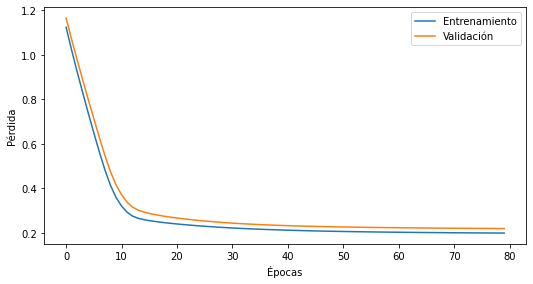

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
pyplot.figure(figsize=(19, 20))
i=0
h= histories[0]
plot_no = 420 + (i+1)
pyplot.subplot(plot_no)
plt.plot(h['loss'], label='Entrenamiento')
plt.plot(h['val_loss'], label='Validación')

plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
pyplot.figure(figsize=(5, 5))

In [ ]:
nombreModelo= "/content/drive/My Drive/Colab Notebooks/Datos2/LSTM_trivariada_Smoteen_Modelo"

#-------- GUARDA LOS MODELOS --------

In [ ]:
# serializa el modelo para JSON
for i in range(cantidad_modelos):
  model_json = models[i].to_json()
  with open(nombreModelo+str(i)+".json", "w") as json_file:
    json_file.write(model_json)
  #serializan los pesos (weights) para HDF5
  models[i].save_weights(nombreModelo+str(i)+".h5")
  # guarda el history
  histories[i].to_csv(nombreModelo+'history_'+str(i)+'.csv',  index = False, header=True)  

print("Modelos guardado en el PC")
json_file.close()

Modelos guardado en el PC


# **Recuperar los modelos**

In [ ]:
# carga el json y crea el modelo
models=[]
histories=[]
m_testPredictRec = []

for i in range(cantidad_modelos):
  json_file = open(nombreModelo+str(i)+".json", 'r')
  loaded_model_json = json_file.read()  
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # se cargan los pesos (weights) en el nuevo modelo
  loaded_model.load_weights(nombreModelo+str(i)+".h5")
  models.append(loaded_model)
  # recupero el loss (mse) y el error (mae) de entrenamiento
  histories.append(pd.read_csv(nombreModelo+'history_'+str(i)+'.csv'))  
  # recupera la prediccion
  m_testPredictRec.append(pd.read_csv(nombreModelo+'prediccion_'+str(i)+'.csv').values.tolist())

print("Modelos recuperados en el PC")

Modelos recuperados en el PC


In [ ]:
m_testPredict = m_testPredictRec

In [ ]:
# make predictions
m_testPredict = []
m_testPredict_scaled = []

for i in range(cantidad_modelos):
  #m1_testPredict = models[i].predict(testX_scaler)
 
  m1_testPredict = np.asarray(m_testPredictRec[i]).reshape(-1,1)
  m_testPredict_scaled.append(m1_testPredict)
  m1_testPredict = scalerY.inverse_transform(m1_testPredict)
  m_testPredict.append(m1_testPredict) 
  

#Evaluación y Predicción

In [ ]:
# make predictions
m_testPredict = []
m_testPredict_scaled = []

for i in range(cantidad_modelos):
  m1_testPredict = models[i].predict(testX_scaler)
  #guarda la predicción en el archivo
  dfp = pd.DataFrame(m1_testPredict,columns =['ypred'])
  dfp.to_csv(nombreModelo+'prediccion_'+str(i)+'.csv',  index = False, header=True)
  
  m1_testPredict = np.asarray(m1_testPredict).reshape(-1,1)
  m_testPredict_scaled.append(m1_testPredict)
  m1_testPredict = scalerY.inverse_transform(m1_testPredict)
  m_testPredict.append(m1_testPredict) 

In [ ]:
 #obtiene el error de cada modelo para el conjunto de datos de test
error_prediction=[]
error_prediction_scaled=[]
for i in range(cantidad_modelos):    
  error_prediction_scaled.append(testY_scaler.reshape(1,-1)[0] - m_testPredict_scaled[i][:,0])
  error_prediction.append(ytest.to_numpy().reshape(1,-1)[0] - m_testPredict[i][:,0])

In [ ]:
print('mse_train mse_val mse_test rmse_train rmse_val rmse_test r2_train r2_val r2_test')
for i in range(cantidad_modelos):
  trainpred= models[i].predict(trainX_scaler)  
  valpred= models[i].predict(validationX_scaler)  

  msetrain= mean_squared_error(ytrain.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(trainpred))  
  mseval =  mean_squared_error(yval.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(valpred))  
  msetest=  mean_squared_error(ytest.to_numpy().reshape(1,-1)[0], m_testPredict[i][:,0]) 

  rmsetrain= sqrt(mean_squared_error(ytrain.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(trainpred))  )
  rmseval=  sqrt(mean_squared_error(yval.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(valpred))) 
  rmsetest= sqrt(mean_squared_error(ytest.to_numpy().reshape(1,-1)[0], m_testPredict[i][:,0]))
  
  r2train= r2_score(ytrain.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(trainpred))
  r2val=   r2_score(yval.to_numpy().reshape(1,-1)[0], scalerY.inverse_transform(valpred))
  r2test= r2_score(ytest.to_numpy().reshape(1,-1)[0], m_testPredict[i][:,0])

  print('{:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} {:8.3f} '.format(msetrain, mseval, msetest, rmsetrain, rmseval,rmsetest, r2train, r2val, r2test))
  

mse_train mse_val mse_test rmse_train mse_val mse_test r2_train r2_val r2_test
   6.084    6.708    6.547    2.467    2.590    2.559    0.808    0.804    0.670 


In [ ]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (30, 10)
plt.rcParams['font.size']=22
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 1

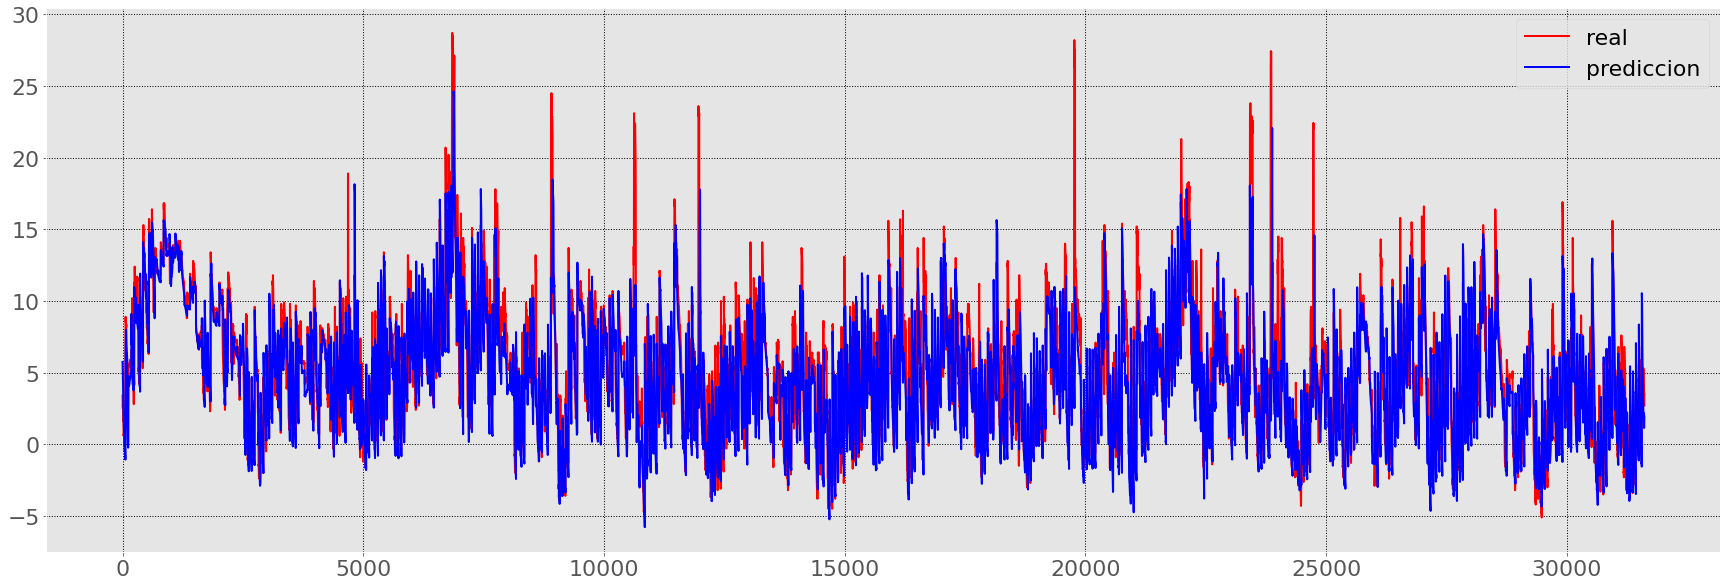

In [ ]:
for i in range(cantidad_modelos):
  plt.plot(ytest.to_numpy().reshape(1,-1)[0], color= "red", label="real")
  plt.plot(m_testPredict[i][:,0], color= "blue", label="prediccion")
  #plt.plot(error_prediction[i], color='green', label= 'error')
  plt.legend()
  plt.show()

#Helada

In [ ]:
index= ytest <= 0
ty= ytest[index]
for i in range(cantidad_modelos):
  py= m_testPredict[i][index]
  print('MSE: %.4f ' % (mean_squared_error(ty, py, squared= True)))

MSE: 2.2694 


In [ ]:
f_es_helada = lambda x : 0 if (x <= 0) else 1
i= 0
for i in range(len(models)):  
  binario_real = list(map(f_es_helada, ytest))
  binario_pred = list(map(f_es_helada, m_testPredict[i]))
  print("precision{:7.3f}".format(accuracy_score(binario_real, binario_pred)) )
  print(confusion_matrix(binario_real, binario_pred))
  print(classification_report(binario_real, binario_pred)) 
  i+=1

precision  0.920
[[ 2789   971]
 [ 1565 26288]]
              precision    recall  f1-score   support

           0       0.64      0.74      0.69      3760
           1       0.96      0.94      0.95     27853

    accuracy                           0.92     31613
   macro avg       0.80      0.84      0.82     31613
weighted avg       0.93      0.92      0.92     31613



#Analisis de resultados

In [ ]:
py= m_testPredict[0][index]
#diferencia= ty - py
yreales= ty.to_numpy()
ypredichos= py.reshape(-1)
print(yreales)
print(ypredichos)

[-0.1  0.  -0.2 ... -0.4 -0.3 -0.2]
[ 0.44003927  0.28751057  0.0401163  ... -1.17761058 -1.30142981
 -1.31827113]


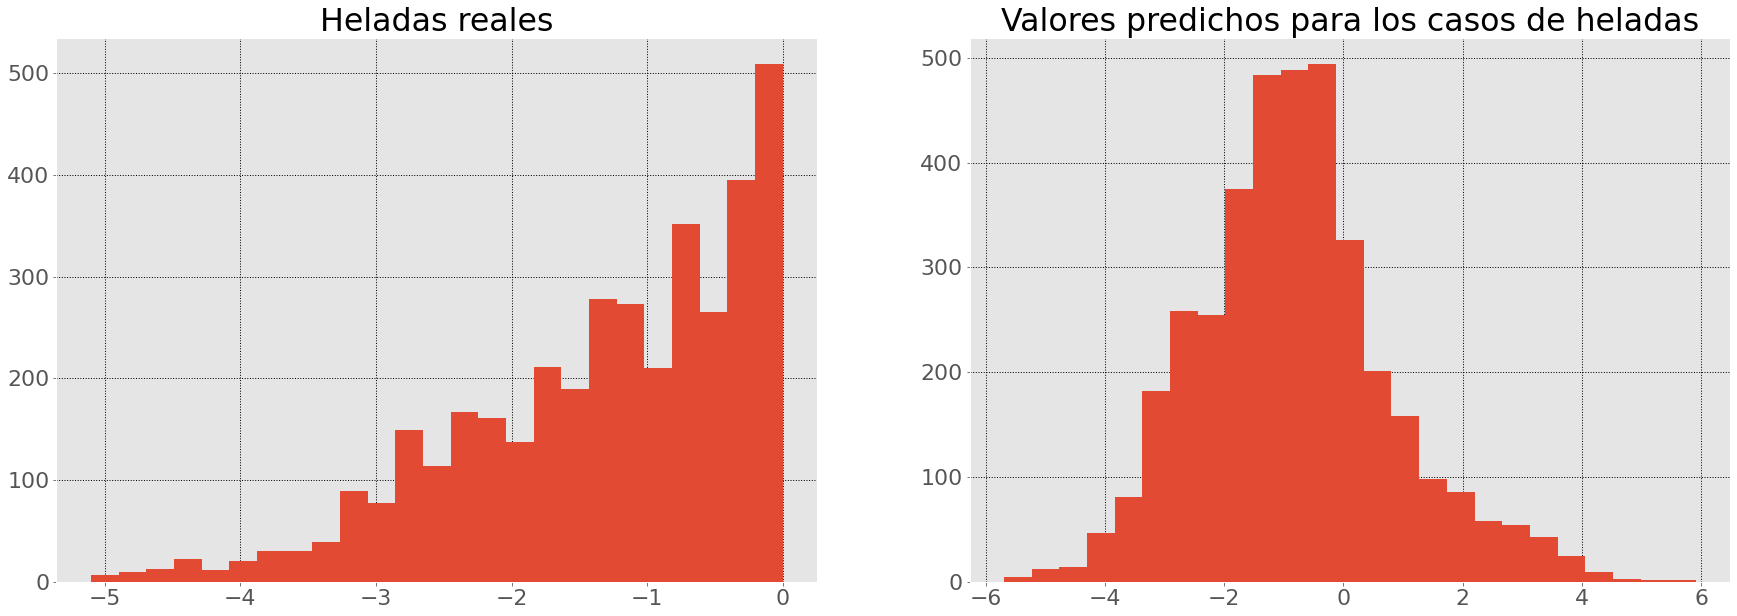

In [ ]:
plt.subplot(1,2,1)
#plt.figure(figsize=(10,5))
plt.hist(yreales, bins=25)
plt.title('Heladas reales')

plt.subplot(1,2,2)
plt.hist(ypredichos, bins=25)
plt.title('Valores predichos para los casos de heladas')
plt.show()


In [ ]:
diferencia1= yreales - ypredichos
print(min(diferencia1), max(diferencia1))

-6.112618536024091 4.492167872865522


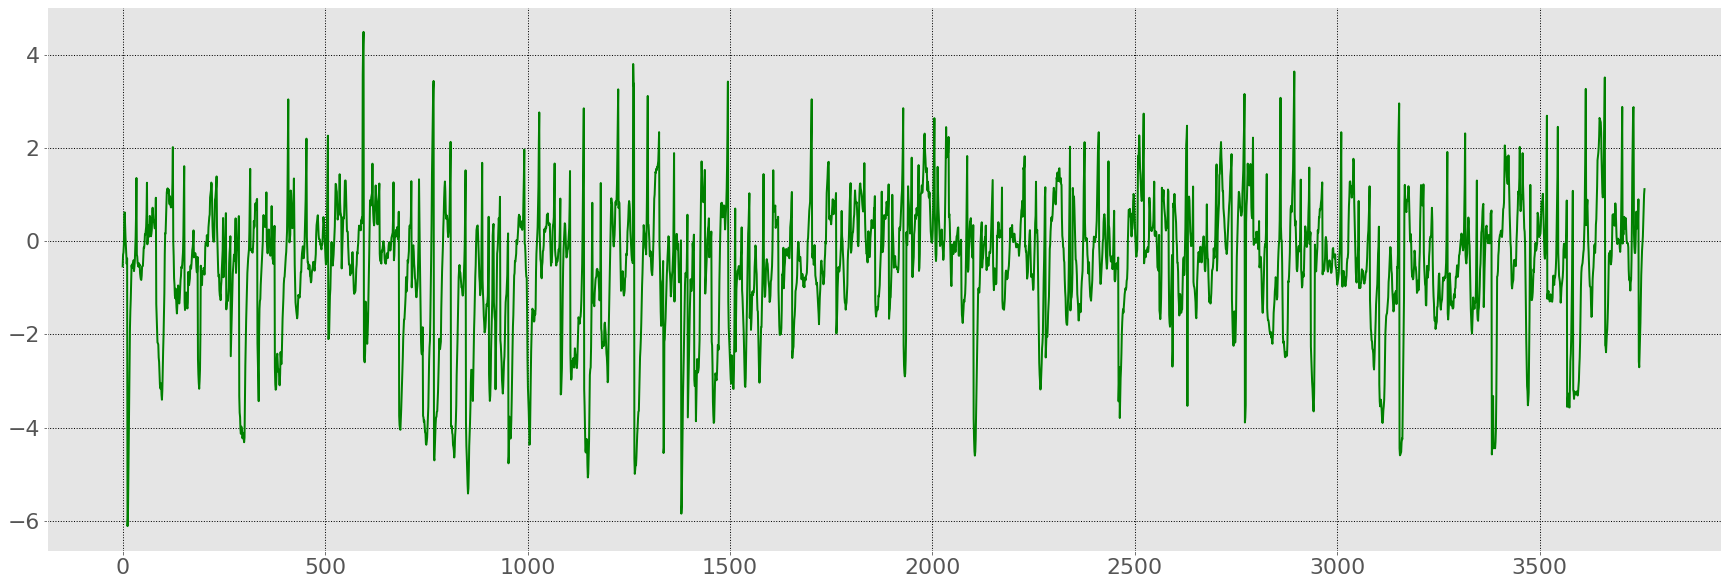

In [ ]:
 plt.plot(diferencia1, color= "green", label="Error")
 plt.show()

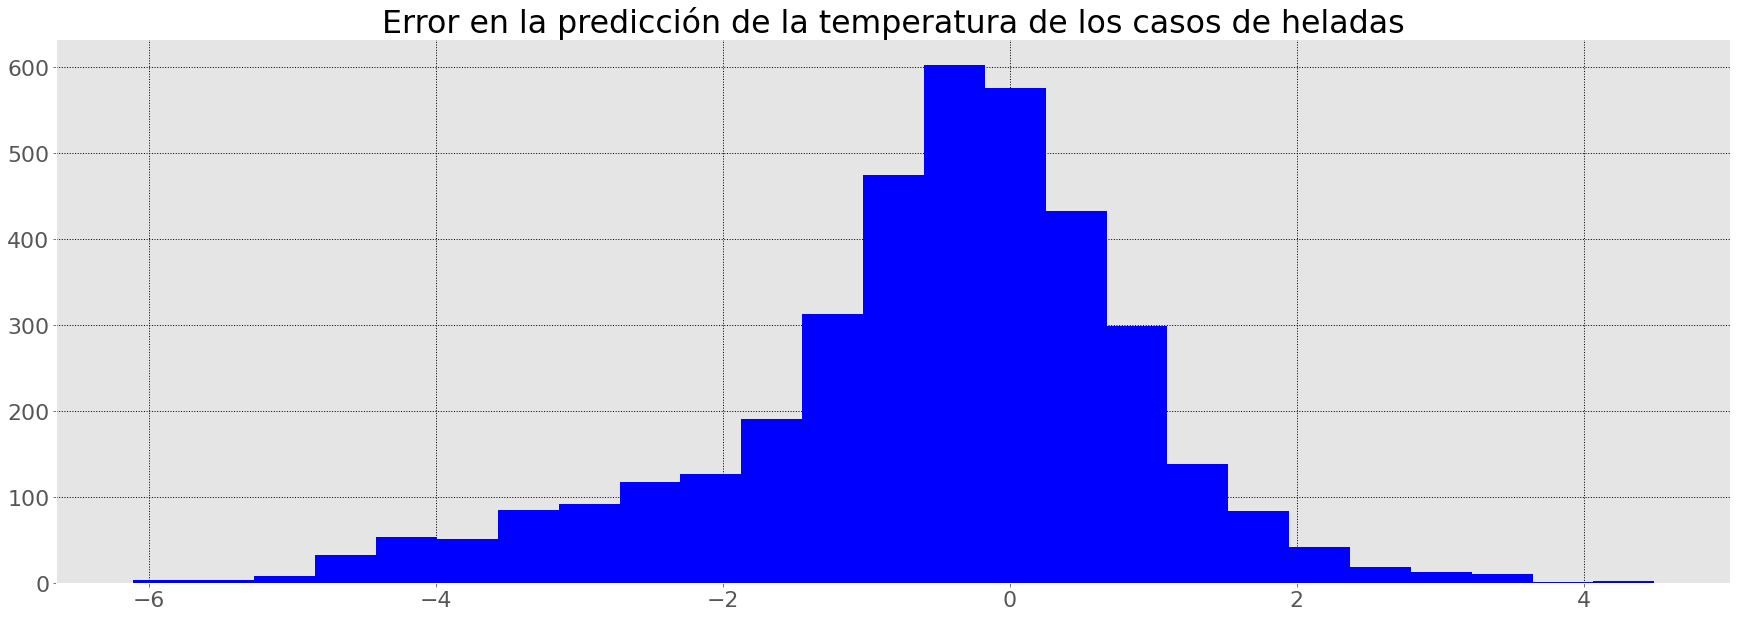

In [ ]:
plt.hist(diferencia1, bins=25,color = "blue")
plt.title('Error en la predicción de la temperatura de los casos de heladas')
plt.show()

In [ ]:
#yreales son las heladas reales
predicciones_menores= yreales > ypredichos
#predicciones_mayores= yreales < ypredichos
#ocurrencias = dict((i, predicciones_menores.count(i)) for i in predicciones_menores)
print(predicciones_menores)
import collections

counter = collections.Counter(predicciones_menores)
print(counter)

[False False False ...  True  True  True]
Counter({False: 2413, True: 1347})


In [ ]:
2789-1347

1442

In [ ]:
144200/2789

51.70311939763356

In [ ]:
predicciones_mayores= yreales < ypredichos
print(predicciones_mayores)
counter = collections.Counter(predicciones_mayores)
print(counter)

[ True  True  True ... False False False]
Counter({True: 2413, False: 1347})


In [ ]:
2022+1738

3760

In [ ]:
# de las predicciones mayores al valor real, cuantas son negativas
heladaspredichasmayores= ypredichos[predicciones_mayores]
counter = collections.Counter(heladaspredichasmayores <=0)
print(counter)


Counter({True: 1442, False: 971})


In [ ]:
1170+852

2022

In [ ]:
# porcentaje de pronostioco con temperaturas menores a cero
117000/2908

40.23383768913342

In [ ]:
predicciones_menores= yval<=0
print(predicciones_menores)
import collections

counter = collections.Counter(predicciones_menores)
print(counter)

0         True
1         True
2         True
3         True
4         True
         ...  
21863    False
21864    False
21865    False
21866    False
21867    False
Name: Y, Length: 21868, dtype: bool
Counter({True: 11058, False: 10810})


Para el modelo trivariado, de 1.733 heladas fueron predichas con una temperatura menor a la real, esto es aproximadamente el 59%. En cambio, para 1.175 heladas fueron predichas con una temperatura mayor a la helada real.

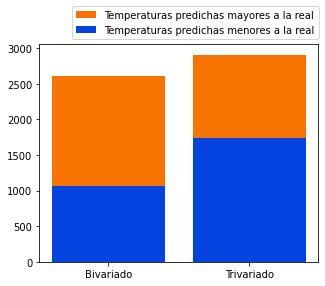

In [ ]:

menores=[1065,1733]
mayores=[1548 ,1175]

lasx=['Bivariado','Trivariado']

plt.figure(figsize=(5,4))
plt.bar(lasx,mayores,color="#F97303",bottom=np.array(menores),label="Temperaturas predichas mayores a la real")
plt.bar(lasx,menores,color="#0343DF",label="Temperaturas predichas menores a la real")

plt.legend(loc="lower left",bbox_to_anchor=(0.1,1),ncol=1)
plt.show()

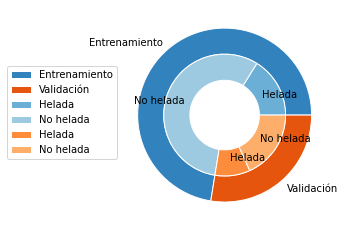

In [ ]:
from matplotlib.cm import get_cmap

fig, ax = plt.subplots()

size = 0.3
vals = np.array([[9838,	34365], [5686,	11122]])

cmap = get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap([1, 2, 5, 6])

labels_inner = ["Helada", "No helada", "Helada", "No helada"]
labels_outer = ["Entrenamiento", "Validación"]

# outer slices
ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=labels_outer)

# inner slices
ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=labels_inner, labeldistance=0.7)

#ax.set(aspect="equal", title='Conjunto de datos')
plt.legend(loc=(-0.5, 0.3))
ax.set(aspect="equal")

plt.show()

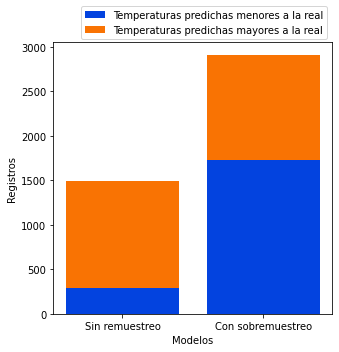

In [ ]:
x = ["Sin remuestreo", "Con sobremuestreo"]
y2 = [290, 1733]
y1 = [1497-290,2908 -1733 ] 

plt.figure(figsize=(5, 5))
# plot bars in stack manner
plt.bar(x, y2, color='#0343DF')
plt.bar(x, y1, bottom=y2, color='#F97303')

plt.xlabel("Modelos")
plt.ylabel("Registros")

plt.legend(["Temperaturas predichas menores a la real", "Temperaturas predichas mayores a la real"],  bbox_to_anchor =(1, 1.15), ncol = 1)
plt.show()

In [ ]:
x = ["Entrenamiento", "Validación"]
y1 = [len(trainX_scaler)- len(df_sftrain),len(validationX_scaler)-len(df_sfval)]
y2 = [len(df_sftrain), len(df_sfval)]

plt.figure(figsize=(5, 5))
# plot bars in stack manner
plt.bar(x, y2, color='#0343DF')
plt.bar(x, y1, bottom=y2, color='#F97303')

plt.xlabel("Datos")
plt.ylabel("Registros")
plt.legend(["Original", "Sobremuestreo"],  bbox_to_anchor =(0.75, 1.15), ncol = 2)
plt.title("Sobremuestreo con SMOTEEN")
plt.show()

#**Heladas tardías**

In [ ]:
#indices de las healdas tardias en el conjunto de test
index_heladas_tardias= (df_test['Y']<=0) & (df_test.DateTime.dt.month >=8)

In [ ]:
counter = collections.Counter(index_heladas_tardias)
print(counter)

Counter({False: 30896, True: 717})


In [ ]:
heladas_tardias= ytest[index_heladas_tardias]
for i in range(cantidad_modelos):
  pytardia= m_testPredict[i][index_heladas_tardias]
  print('MSE: %.4f ' % (mean_squared_error(pytardia, heladas_tardias, squared= True)))

MSE: 2.2923 


In [ ]:
f_es_helada_tardia = lambda x : 0 if (x <= 0) else 1
i= 0
for i in range(len(models)):  
  binario_real_tardia = list(map(f_es_helada_tardia, heladas_tardias))
  binario_pred_tardia = list(map(f_es_helada_tardia, m_testPredict[i][index_heladas_tardias]))
  print("precision{:7.3f}".format(accuracy_score(binario_real_tardia, binario_pred_tardia)) )
  print(confusion_matrix(binario_real_tardia, binario_pred_tardia))
  print(classification_report(binario_real_tardia, binario_pred_tardia)) 
  i+=1

precision  0.706
[[506 211]
 [  0   0]]
              precision    recall  f1-score   support

           0       1.00      0.71      0.83       717
           1       0.00      0.00      0.00         0

    accuracy                           0.71       717
   macro avg       0.50      0.35      0.41       717
weighted avg       1.00      0.71      0.83       717



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pytardia= m_testPredict[0][index_heladas_tardias]

In [ ]:
# todas las heladas tardías del conjunto de test
df_heladas_tardias= df_test[(df_test.DateTime.dt.month >=8) & (df_test['Y'] <=0)]
# agrega la prediccion para los casos de heladas tardias
#index_heladas_tardias= (df_test['Y']<=0) & (df_test.DateTime.dt.month >=8)
df_heladas_tardias['Prediccion']= m_testPredict[0][index_heladas_tardias]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
df_heladas_tardias[df_heladas_tardias.DateTime.dt.month ==9]

In [ ]:
errores= df_heladas_tardias['Prediccion'] > 0


In [ ]:
diferencia_heladas_tardias_erroneas = df_heladas_tardias['Prediccion'][errores] - df_heladas_tardias['Y'][errores]

In [ ]:
print(min(df_heladas_tardias['Y'][errores]), max(df_heladas_tardias['Y'][errores]))

-2.3 0.0


In [ ]:
print(min(diferencia_heladas_tardias_erroneas), max(diferencia_heladas_tardias_erroneas))

0.04243640122757686 5.845201497079756


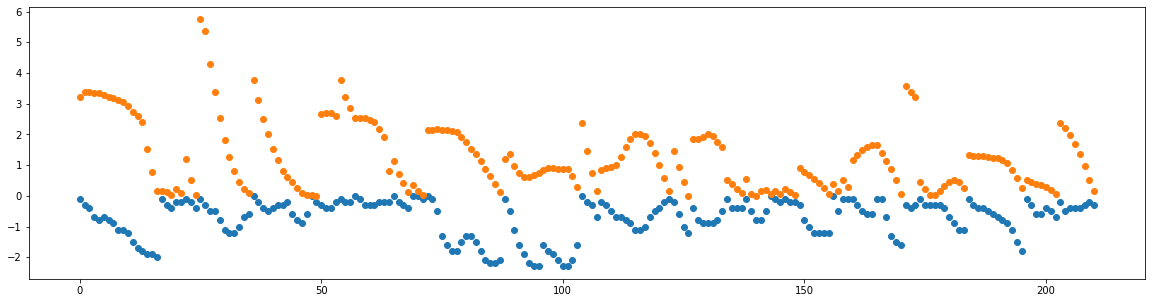

In [ ]:
plt.figure(figsize=(20, 5))
x= range(len(diferencia_heladas_tardias_erroneas))
#plt.scatter(x, diferencia_heladas_tardias_erroneas )
plt.scatter(x, df_heladas_tardias['Y'][errores])
plt.scatter(x, df_heladas_tardias['Prediccion'][errores])
plt.show()